In [1]:
import random
import math
import torch 
import torch.nn as nn
import torchvision
from torchvision.models import resnet18
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# cuda device name
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 2060


In [4]:
# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

## CNN Models

Here we define two CNN models: one is a two-layer CNN model and the other one is the classic ResNet18 model. By switching the the flag `useSimple` to **True** or **False**, we can select either of them.

In [5]:
# select one model
useSimple = True    # use simple model

# useSimple = False   # use Resnet18

### Simple model

In [6]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        
        # input shape: (None,1,28,28)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2), #output shape: (None,16,28,28)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #output shape: (None,16,14,14)
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), #output shape: (None,32,14,14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #output shape: (None,32,7,7)
        
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        
        # input shape: (None,1,28,28)
        out = self.layer1(x) #output shape: (None,16,14,14)
        out = self.layer2(out) #output shape: (None,32,7,7)
        
        """The reshape function also consider the 0th, i.e. batch dimension, different from Keras.Reshape!"""
        out = out.reshape(out.size(0), -1) #output shape: (None,32*7*7)
        out = self.fc(out) #output shape: (None,10)
        
        return out

In [7]:
# build the model
modelA = ConvNet(num_classes)

### Resnet18 model

In [8]:
# MNIST has 10 classes
modelB = resnet18(num_classes=num_classes)

# we need to adapt this architecture for MNIST, there is one more thing required: input layer needs to accept 1 channel instead of 3.
# here MNIST images are single-channel = grayscale, whereas ImageNet are 3-channels = RGB
modelB.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

## MNIST dataset

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels. The MNIST database contains 60,000 training images and 10,000 testing images.

In [9]:
# where to save downloaded MNIST dataset
data_root = './data'

In [10]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=data_root,
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root=data_root,
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

## QC training data

In [11]:
def plot_mnist(sample_imgs, sample_labels):

    nimgs = int(math.sqrt(sample_imgs.shape[0]))
    
    plt.figure(figsize=(10, 10))
    
    for x in range(nimgs*nimgs):
        
        plt.subplot(nimgs,nimgs,x+1)
    
        plt.imshow(sample_imgs[x], cmap='gray', interpolation='none')
        
        plt.title("Label: {}".format(sample_labels[x]))
        plt.xticks([])
        plt.yticks([])
        
    plt.tight_layout()

In [12]:
# extract some data for display
sample_dataset = enumerate(train_loader)
_, (sample_imgs, sample_labels) = next(sample_dataset)

In [13]:
sample_imgs = sample_imgs.squeeze()
sample_imgs.shape

torch.Size([100, 28, 28])

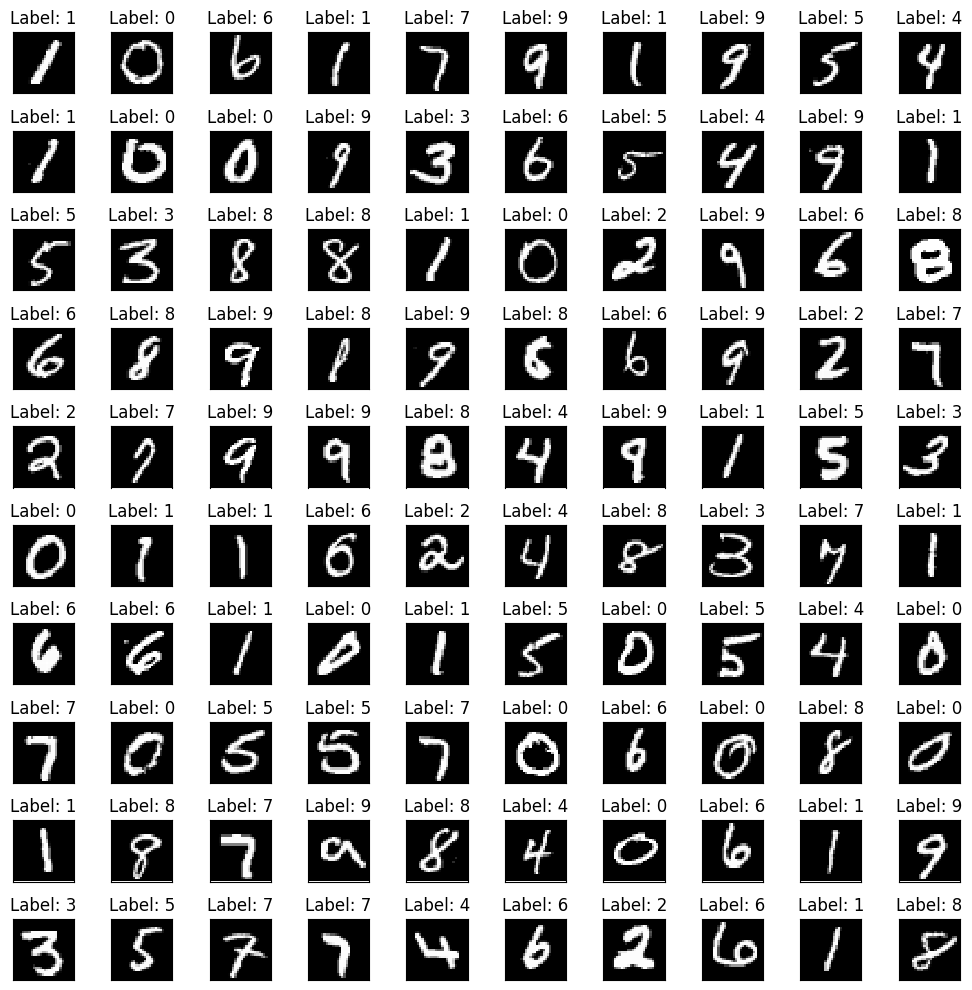

In [14]:
plot_mnist(sample_imgs, sample_labels)

## Training the CNN model

In [15]:
if useSimple:
    model = modelA.to(device)
else:
    model = modelB.to(device)

In [16]:
# Loss function
criterion = nn.CrossEntropyLoss()

# and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):

    model.train()
    
    for i, (images, labels) in enumerate(train_loader):
        
        """PyTorch is channel first, different from TensorFlow!"""
        """images.size(): torch.Size([100, 1, 28, 28])"""
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward 
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.1326
Epoch [1/5], Step [200/600], Loss: 0.0719
Epoch [1/5], Step [300/600], Loss: 0.0981
Epoch [1/5], Step [400/600], Loss: 0.0401
Epoch [1/5], Step [500/600], Loss: 0.0194
Epoch [1/5], Step [600/600], Loss: 0.1164
Epoch [2/5], Step [100/600], Loss: 0.1461
Epoch [2/5], Step [200/600], Loss: 0.0525
Epoch [2/5], Step [300/600], Loss: 0.0485
Epoch [2/5], Step [400/600], Loss: 0.0270
Epoch [2/5], Step [500/600], Loss: 0.0152
Epoch [2/5], Step [600/600], Loss: 0.0464
Epoch [3/5], Step [100/600], Loss: 0.0655
Epoch [3/5], Step [200/600], Loss: 0.0298
Epoch [3/5], Step [300/600], Loss: 0.0588
Epoch [3/5], Step [400/600], Loss: 0.0191
Epoch [3/5], Step [500/600], Loss: 0.0099
Epoch [3/5], Step [600/600], Loss: 0.0081
Epoch [4/5], Step [100/600], Loss: 0.0113
Epoch [4/5], Step [200/600], Loss: 0.0457
Epoch [4/5], Step [300/600], Loss: 0.0058
Epoch [4/5], Step [400/600], Loss: 0.0059
Epoch [4/5], Step [500/600], Loss: 0.0206
Epoch [4/5], Step [600/600], Loss:

## Test the model with new data

In [18]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

# has effect on specific layers like Dropout and BatchNorm
with torch.no_grad():
    
    correct = 0
    total = 0
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        # prediction
        outputs = model(images)
        
        #Tensor.data: tensor
        _, predicted = torch.max(outputs.data, 1)  # (None, 10)
        
        #Tensor.size(): torch.Size, Tensor.size(0): int
        total += labels.size(0)
        
        #Tensor.item(): number
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 98.9 %


## QC test data

In [19]:
test_iter = iter(test_loader)

In [20]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

# has effect on specific layers like Dropout and BatchNorm
with torch.no_grad():
    
    images, labels = next(test_iter)
        
    images = images.to(device)
    labels = labels.to(device)

    # prediction
    outputs = model(images)

In [21]:
# to the cpu
images = images.detach().cpu().numpy().squeeze()  # remove channel
labels = labels.detach().cpu().numpy()

In [22]:
images.shape, labels.shape

((100, 28, 28), (100,))

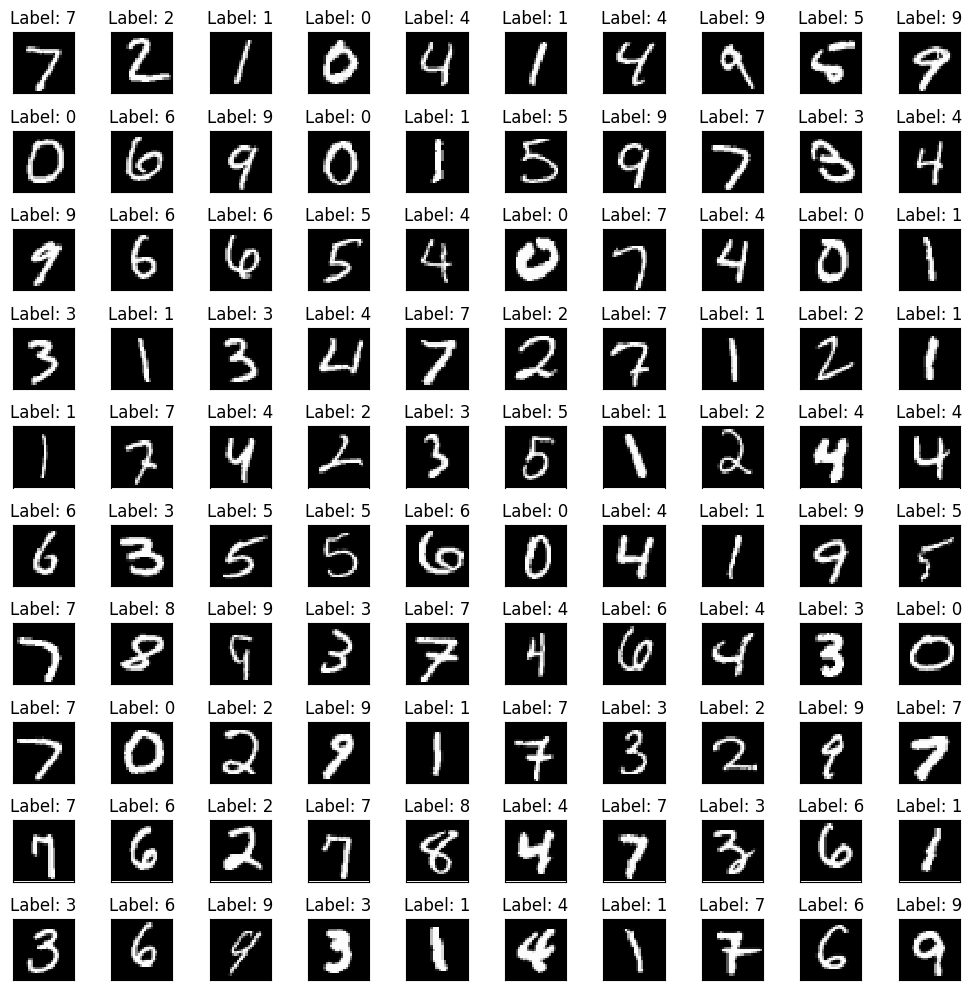

In [23]:
# extract some data for display
plot_mnist(images, labels)

## Save the model to disk

In [24]:
# Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')